In [16]:
%matplotlib inline
from __future__ import division
import cvxpy as cvx
import matplotlib.pyplot as plt
import numpy as np

x (2000, 2) y (2000,)


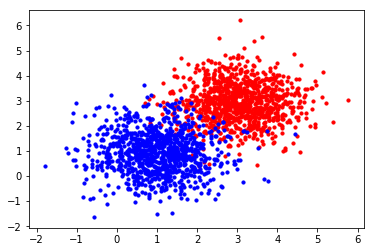

In [17]:
###Data Generation
DIM = 2
COLORS = ['red', 'blue']
np.random.seed(2)
M1 = np.ones((DIM,))
M2 = 3 * np.ones((DIM,))
C1 = np.diag(0.7 * np.ones((DIM,)))
C2 = np.diag(0.6 * np.ones((DIM,)))
fig, ax = plt.subplots()
def generate_gaussian(m, c, num):
    return np.random.multivariate_normal(m, c, num)
def plot_data_with_labels(ax, x, y):
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        ax.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li], s=10)
def evaluate(y_hat, y_test):
    num_right = np.sum(y_hat==y_test)
    num_total = y_hat.shape[0]
    num_wrong = num_total - num_right
    top1accuracy = num_right/(num_total)
    top1error = num_wrong/num_total
    print "correct rate : ", num_right, "/", num_total
    print "top 1 accuracy", top1accuracy
    print "top 1 error", top1error
    
NUM = 1000
NUM_test = int(NUM*0.2)
NUM_total = NUM + NUM_test
x1 = generate_gaussian(M1, C1, NUM_total)
y1 = np.ones((x1.shape[0],))
x2 = generate_gaussian(M2, C2, NUM_total)
y2 = -np.ones((x2.shape[0],))

x_train = np.concatenate((x1[:-NUM_test,:], x2[:-NUM_test,:]), axis = 0)
x_test = np.concatenate((x1[-NUM_test:,:], x2[-NUM_test:,:]), axis =0)

y_train = np.concatenate((y1[:-NUM_test], y2[:-NUM_test]), axis = 0)
y_test = np.concatenate((y1[-NUM_test:], y2[-NUM_test:]), axis = 0)

print('x {} y {}'.format(x_train.shape, y_train.shape))
plot_data_with_labels(ax, x_train, y_train)

In [18]:
y = np.expand_dims(a=y_train, axis=1)
beta = cvx.Variable(2)
v = cvx.Variable()
epsilon = cvx.Variable(1,NUM*2)
C = cvx.Parameter(value=1.5)
loss = (0.5 * cvx.square(cvx.norm(beta))) + cvx.mul_elemwise(C,cvx.sum_entries(epsilon))
const = []
for i  in range(epsilon.size[1]):
    const.append(cvx.mul_elemwise(y_train[i],x_train[i]*beta+v) >= 1 - epsilon[i])
    const.append(epsilon[i]>=0)
prob = cvx.Problem(cvx.Minimize(loss), const)
import time
start_time = time.time()
prob.solve(verbose=True)
end_time = time.time()
print end_time - start_time


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.964e+02  +3.571e+03  +2e+04  7e-01  6e+00  1e+00  5e+00    ---    ---    1  2  - |  -  - 
 1  +3.903e+02  +2.366e+03  +1e+04  4e-01  4e+00  2e+00  4e+00  0.3863  3e-01   2  1  1 |  0  0
 2  +4.286e+02  +8.915e+02  +5e+03  9e-02  9e-01  1e+00  1e+00  0.7347  8e-02   2  1  2 |  0  0
 3  +3.770e+02  +5.680e+02  +2e+03  3e-02  4e-01  5e-01  5e-01  0.6837  1e-01   2  1  1 |  0  0
 4  +3.732e+02  +5.592e+02  +2e+03  3e-02  4e-01  4e-01  5e-01  0.1299  7e-01   2  1  2 |  0  0
 5  +3.427e+02  +4.341e+02  +9e+02  1e-02  2e-01  2e-01  2e-01  0.7964  3e-01   2  1  1 |  0  0
 6  +3.275e+02  +3.703e+02  +4e+02  7e-03  1e-01  7e-02  1e-01  0.6252  1e-01   2  1  1 |  0  0
 7  +3.211e+02  +3.452e+02  +2e+02  4e-03  6e-02  4e-02  6e-02  0.5151  1e-01   3  1  1 |  0  0
 8  +3.169e+02  +3.288e+02  +1e+02  2e-03  3e-

In [19]:
_beta = np.array(beta.value)
_beta_0 = v.value
x_ = np.arange(0, 5)
slope = -_beta[0]/_beta[1]
inter = -_beta_0/_beta[1]

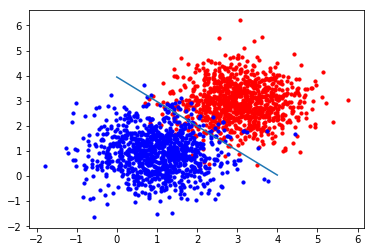

In [20]:
ax.plot(x_, x_ * slope + inter)
fig

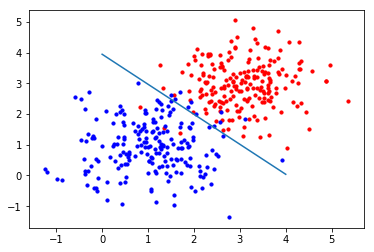

In [21]:
fig2, ax2 = plt.subplots()
plot_data_with_labels(ax2, x_test, y_test)
ax2.plot(x_, x_ * slope + inter)

In [22]:
y_hat = np.dot(x_test,_beta) + _beta_0
y_hat = np.sign(y_hat.squeeze())
evaluate(y_hat,y_test)

correct rate :  386 / 400
top 1 accuracy 0.965
top 1 error 0.035


In [23]:
# Dual form
alpha = cvx.Variable(2*NUM)
C = cvx.Parameter(value=1.5)
P = (np.diag(y_train) * np.dot(x_train,x_train.T) * np.diag(y_train))
loss = cvx.sum_entries(alpha) -0.5*cvx.quad_form(alpha, P)
const = []
for i  in range(2*NUM):
    const.append(0 <= alpha[i])
    const.append(alpha[i] <= C)
const.append(((alpha.T)*y_train)==0)
prob = cvx.Problem(cvx.Maximize(loss), const)
start_time = time.time()
prob.solve(verbose=True)
# prob.solve(solver="CVXOPT",verbose=True)
end_time = time.time()
print end_time - start_time


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.500e+03  -6.000e+03  +1e+04  3e-01  5e-03  1e+00  3e+00    ---    ---    2  2  - |  -  - 
 1  -2.934e+03  -3.334e+03  +1e+03  2e-02  4e-04  7e-01  4e-01  0.9478  9e-02   1  2  2 |  0  0
 2  -2.929e+03  -3.298e+03  +1e+03  2e-02  3e-04  5e-01  3e-01  0.4328  8e-01   1  2  3 |  0  0
 3  -2.877e+03  -3.305e+03  +1e+03  3e-02  4e-05  6e-01  3e-01  0.0442  1e+00   4  4  3 |  0  0
 4  -2.796e+03  -3.269e+03  +1e+03  3e-02  2e-05  8e-01  3e-01  0.1838  4e-01   2  3  4 |  0  0
 5  -2.388e+03  -2.888e+03  +6e+02  6e-02  1e-05  1e+00  2e-01  0.6255  2e-01   3  3  4 |  0  0
 6  -2.312e+03  -2.775e+03  +5e+02  6e-02  9e-06  1e+00  1e-01  0.2138  3e-01   4  4  3 |  0  0
 7  -2.286e+03  -2.683e+03  +5e+02  5e-02  7e-06  7e-01  1e-01  0.4424  7e-01   3  4  3 |  0  0
 8  -1.629e+03  -1.871e+03  +2e+02  4e-02  4e-

In [24]:
_alpha = np.array(alpha.value)
y_ = np.expand_dims(y_train,1)
__beta = _alpha * y_ * x_train
_beta = np.sum(__beta, axis=0)
y_ = np.expand_dims(y_train,1)
sum_val = 0
for j in range(2*NUM):
    _x = np.expand_dims(x_train[j],1)
    sum_val += np.sum(1/y_train[j] - (_alpha*y_)*np.dot(x_train,_x))
_beta_0 = sum_val/(2*NUM)
_beta_0

1037.3072957214035

In [25]:
x_ = np.arange(0, 5)
slope = -_beta[0]/_beta[1]
inter = -_beta_0/_beta[1]

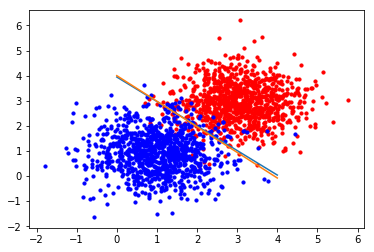

In [26]:
ax.plot(x_, x_ * slope + inter)
fig

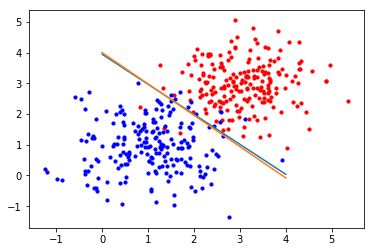

In [27]:
ax2.plot(x_, x_ * slope + inter)
fig2

In [28]:
y_hat = np.dot(x_test,_beta) + _beta_0
y_hat = np.sign(y_hat.squeeze())
evaluate(y_hat,y_test)

correct rate :  386 / 400
top 1 accuracy 0.965
top 1 error 0.035
